In [ ]:
import torch
import torchvision
from torchvision import datasets,transforms


In [ ]:
train = datasets.MNIST('',train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train,batch_size = 32,shuffle = True)
test = datasets.MNIST('',train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
testset = torch.utils.data.DataLoader(test,batch_size = 32,shuffle = True)
print(train.data.size())

torch.Size([60000, 28, 28])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    #encoding layers
    self.conv1 = nn.Conv2d(1,32,3,padding=1,stride=2)
    self.conv2 = nn.Conv2d(32,64,3,padding=1,stride=2)
    self.conv3 = nn.Conv2d(64,128,5)


    #decoding layers
    self.tconv1 = nn.ConvTranspose2d(128,64,5)
    self.tconv2 = nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1)
    self.tconv3 = nn.ConvTranspose2d(32,1,3,stride=2,padding=1,output_padding=1)

  
  #forward prop function 
  def forward(self,x):
    x = F.relu(self.conv1(x))
    # print(x.size())
    x = F.relu(self.conv2(x))
    # print(x.size())
    x = F.relu(self.conv3(x))
    # print(x.size())

    x = F.relu(self.tconv1(x))
    # print(x.size())
    x = F.relu(self.tconv2(x))
    # print(x.size())
    x = F.sigmoid(self.tconv3(x)) #final layer is applied sigmoid activation
    # print(x.size())

    return x

model = Model()
print(model)


Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (tconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (tconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [ ]:
model.to(device) #shifting model to cuda

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (tconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (tconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [ ]:
import torch.optim as optim
loss_function = nn.MSELoss() #mean-squared error loss_function
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
#function to add noise to input images
def add_noise(inputs,noise_factor=0.3):
  noisy = inputs + (torch.randn_like(inputs) * noise_factor)
  noisy = torch.clip(noisy,0.,1.)
  return noisy

In [ ]:
losses = [] #list containing average loss of each epoch
running_loss = 0
l = len(trainset)

#training loop
for epoch in range(10):
  for t in trainset:
    images,_ = t
    noisy_images = add_noise(images)
    images = images.to(device)
    noisy_images = noisy_images.to(device) #shifting noisy images to cuda
    
    model.zero_grad()
    output = model(noisy_images)
    
    loss = loss_function(output,images) #loss is calculated between model output and og dataset images
    loss.backward()
    optimizer.step()

    running_loss+=loss.item() 
  losses.append(running_loss/l)
  running_loss = 0
  print(loss) #prints loss of the last batch of the epoch

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
#moving images to cpu for plotting
noisy_images_cpu = noisy_images.cpu()
output_cpu = output.cpu()

[0.01429022889956832, 0.005862985095381737, 0.0053969312414526936, 0.005142434365550677, 0.004994625572984418, 0.004893096757183473, 0.004813497733324766, 0.004734451262777051, 0.0046844772449384136, 0.004632013918583592]


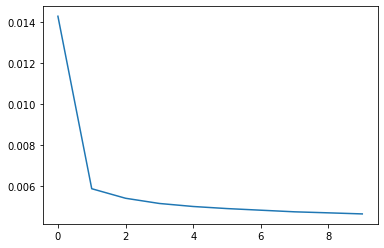

In [ ]:
import matplotlib.pyplot as plt
print(losses)
plt.plot(losses)


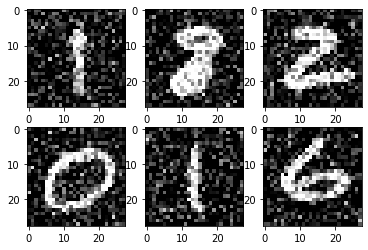

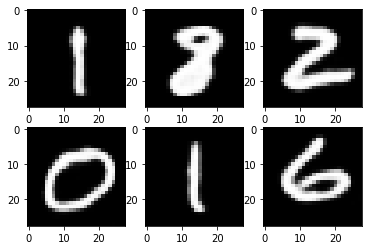

In [ ]:
noisy_images_cpu = noisy_images_cpu.detach().numpy()
noisy_images_cpu = noisy_images_cpu.reshape(-1,28,28)
output_cpu = output_cpu.detach().numpy()
output_cpu = output_cpu.reshape(-1,28,28)
for j in range(6):
  plt.subplot(2,3,j+1)
  plt.imshow(noisy_images_cpu[j],cmap='gray')
plt.show()  
for j in range(6):
  plt.subplot(2,3,j+1)
  plt.imshow(output_cpu[j],cmap='gray') 
plt.show() 

In [ ]:
#finding results on testset
with torch.no_grad():
  for img,_ in testset:
    noisy_img = add_noise(img)
    noisy_img = noisy_img.to(device)
    reconstructed = model(noisy_img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
noisy_img = noisy_img.cpu()
reconstructed = reconstructed.cpu()

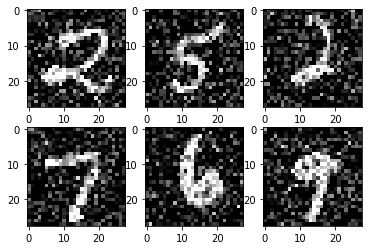

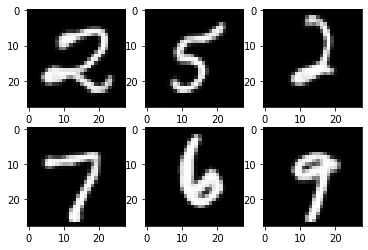

In [ ]:
noisy_img = noisy_img.detach().numpy()
noisy_img = noisy_img.reshape(-1,28,28)
reconstructed = reconstructed.detach().numpy()
reconstructed = reconstructed.reshape(-1,28,28)
for p in range(6):
  plt.subplot(2,3,p+1)
  plt.imshow(noisy_img[p],cmap='gray')
plt.show()
for p in range(6):
  plt.subplot(2,3,p+1)
  plt.imshow(reconstructed[p],cmap='gray')  
plt.show()  